In [1]:
%matplotlib inline 
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

# San Diego Promise Zone Spatial Analysis

Food choices in low and medium income (LMI) neighborhoods are limited, as these areas lack healthy food stores or other fresh food delivery mechanisms. There may be more fast food stores than fresh produce shops. Population is relatively poor, and filling the food basket with healthy options hasn't been an overwhelming priority for many households. Such areas are referred to as "food deserts".

Goal: to analyze the current state of the San Diego Promise Zone, using lists of businesses that operate in San Diego, and social-demographic data from SanDAG (by census tracts).

*Mini Project for the UCSD course DSC 170: Spatial Data Science and Applications taught by professor Ilya Zaslavsky*

## Read in data, merge census tract with socio-demographic data

- Promise Zone Dataset: http://rdw.sandag.org/Account/GetFSFile.aspx?dir=Business&Name=Promise_Zone_SD.zip 
The title of this dataset is Promise_Zone_SD. There is 1 record, and the crs is epsg:2230. 

- Census Tract Dataset: http://rdw.sandag.org/Account/GetFSFile.aspx?dir=Census&Name=CENSUS_TRACTS_2010.zip 
The title of this dataset is CENSUS_TRACTS_2010. There are 627 records, and the crs is epsg:2230. 

- Jurisdiction (Municipal Boundaries) Dataset:http://rdw.sandag.org/Account/GetFSFile.aspx?dir=Jurisdiction&Name=Municipal_Boundaries.zip 
The title of this dataset is MUNICIPAL_BOUNDARIES. There are 70 records, and the crs is epsg:2230. 

- Socio-Demographic Dataset: https://sandag.org/index.asp?classid=26&fuseaction=home.classhome 
The title of this dataset is socio-demographic. There are 43890 records. 

- Buisnesses Dataset: https://data.sandiego.gov/datasets/business-listings/ The title of this dataset is sd_businesses_active_since08_datasd. There are 40208 records, and the crs is epsg:4326. 

In [2]:
# read in all data
pz_fp = 'data/Promise_Zone_SD/Promise_Zone_SD.shp'
ct_fp = 'data/CENSUS_TRACTS_2010/CENSUS_TRACTS_2010.shp'
j_fp = 'data/Municipal_Boundaries/MUNICIPAL_BOUNDARIES.shp'
sd_fp = 'data/socio-demographic.xlsx'
buis_fp = 'data/BUSINESS_SITES/BUSINESS_SITES.shp'

promise_zone = gpd.read_file(pz_fp)
census_tract_2010 = gpd.read_file(ct_fp)
juris = gpd.read_file(j_fp)
sd_juris = juris[juris.CODE == 'SD'].dissolve('CODE')
socio_dem = pd.read_excel(sd_fp)
socio_dem_2016 = socio_dem[socio_dem.YEAR == 2016]

# merge census tract with socio-demographic data
ct_sd_merged = census_tract_2010.merge(socio_dem_2016, on='TRACT')

Subset the businesses (figure out, from NAICS descriptions, which businesses are likely to provide healthy food options, and which unhealthy. You can use our suggestions above but also feel free to deviate from them as long as you justify your choices.)
## Subset the businesses
NAICS Name Assignments:
- Healthy food options: FOOD (HEALTH) SUPPLEMENT STORES, GROCERY STORES and GROCERY (EXCEPT CONVENIENCE) STORES.
<br>
- Unhealthy food options: FOOD SERVICES & DRINKING PLACES, FULL-SERVICE RESTAURANTS, LIMITED-SERVICE EATING PLACES, LIMITED-SERVICE RESTAURANTS (a.k.a fast food places), BEER, WINE & LIQUOR STORES, TOBACCO STORES, CONVENIENCE STORES

In [3]:
# Read in buisnesses csv
buis = pd.read_csv('data/sd_businesses_active_since08_datasd.csv')
ca_buis = buis[buis.state == 'CA']

# Define healthy vs unhealthy naics descriptions
healthy = 'FOOD (HEALTH) SUPPLEMENT STORES,GROCERY STORES,GROCERY STORES'.split(',')
unhealthy = ['FOOD SERVICES & DRINKING PLACES',
             'FULL-SERVICE RESTAURANTS',
             'LIMITED-SERVICE EATING PLACES',
             'LIMITED-SERVICE RESTAURANTS',
             'BEER, WINE & LIQUOR STORES',
             'TOBACCO STORES',
             'CONVENIENCE STORES']
buis_healthy = ca_buis[ca_buis.naics_description.isin(healthy)]
buis_unhealthy = ca_buis[ca_buis.naics_description.isin(unhealthy)]

## Determine Tracts
Determine census tracts intersecting with the promise zone, and all other census tracts within the boundary of San Diego.

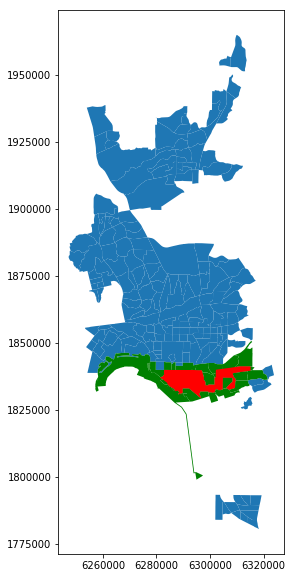

In [4]:
# find intersecting and non-intersecting tracts; plot
intersecting = census_tract_2010[census_tract_2010.intersects(promise_zone.geometry.squeeze())]
non_intersecting = census_tract_2010[census_tract_2010.within(sd_juris.geometry.squeeze())
                                     & ~census_tract_2010.intersects(promise_zone.geometry.squeeze())]
ax = non_intersecting.plot(figsize=(10,10)) 
intersecting.plot(ax=ax, color='green')
promise_zone.plot(ax=ax, color='red')

## Calculate healthy/unhealthy options in tract
For each census tract marked as belonging to the promise zone, and the other tracts within the city limits, calculate the number of healthy and not-healthy options within that tract.

In [7]:
# converting business from df to gdf
healthy_geom = [Point(x, y) for x, y in zip(buis_healthy.longitude, buis_healthy.latitude)]
unhealthy_geom = [Point(x, y) for x, y in zip(buis_unhealthy.longitude, buis_unhealthy.latitude)]

h_buis_crs = {'init': 'epsg:4326'}
h_buis_gdf = gpd.GeoDataFrame(buis_healthy, crs=h_buis_crs, geometry=healthy_geom)
uh_buis_crs = {'init': 'epsg:4326'}
uh_buis_gdf = gpd.GeoDataFrame(buis_unhealthy, crs=uh_buis_crs, geometry=unhealthy_geom)

# finding spatial join between intersecting cities and healthy/unhealthy businesses
intersecting_4326 = intersecting.to_crs({'init':'epsg:4326'})
buis_inters_healthy = gpd.sjoin(h_buis_gdf, intersecting_4326, how='inner', op='within')
buis_inters_unhealthy = gpd.sjoin(uh_buis_gdf, intersecting_4326, how='inner', op='within')

# finding spatial join between intersecting cities and healthy/unhealthy businesses
non_intersecting_4326 = non_intersecting.to_crs({'init':'epsg:4326'})
buis_noninters_healthy = gpd.sjoin(h_buis_gdf, non_intersecting_4326, how='inner', op='within')
buis_noninters_unhealthy = gpd.sjoin(uh_buis_gdf, non_intersecting_4326, how='inner', op='within')

# finding number of (healthy, unhealthy) options in intersecting tracts
healthy_inters_tract = buis_inters_healthy.TRACT.value_counts()
unhealthy_inters_tract = buis_inters_unhealthy.TRACT.value_counts()
inters_zeroes = intersecting_4326[~intersecting_4326.TRACT.isin(buis_inters_healthy.TRACT) &
                                  ~intersecting_4326.TRACT.isin(buis_inters_unhealthy.TRACT)].TRACT
inters_zeroes = inters_zeroes.reindex(inters_zeroes.values)
inters_tract_num_health = (
    pd.concat([healthy_inters_tract, unhealthy_inters_tract, inters_zeroes], axis=1)
    .fillna(0)
    .astype(int)
    .apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
)

# finding number of (healthy, unhealthy) options in non-intersecting tracts
healthy_noninters_tract = buis_noninters_healthy.TRACT.value_counts()
unhealthy_noninters_tract = buis_noninters_unhealthy.TRACT.value_counts()
noninters_zeroes = non_intersecting_4326[~non_intersecting_4326.TRACT.isin(buis_noninters_healthy.TRACT) &
                                         ~non_intersecting_4326.TRACT.isin(buis_noninters_unhealthy.TRACT)].TRACT
noninters_zeroes = noninters_zeroes.reindex(noninters_zeroes.values)
noninters_tract_num_health = (
    pd.concat([healthy_noninters_tract, unhealthy_noninters_tract, noninters_zeroes], axis=1)
    .fillna(0)
    .astype(int)
    .apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
)

print('Number of (healthy, unhealthy) options in intersecting tracts (first 5):')
display(inters_tract_num_health.head())
print('___________________________________________________________________________\n')
print('Number of (healthy, unhealthy) options in non-intersecting tracts (first 5):')
display(noninters_tract_num_health.head())

Number of (healthy, unhealthy) options in intersecting tracts (first 5):


30.01    (0, 0)
30.03    (0, 1)
30.04    (0, 0)
31.01    (0, 0)
31.03    (1, 1)
dtype: object

___________________________________________________________________________

Number of (healthy, unhealthy) options in non-intersecting tracts (first 5):


1.00     (0, 0)
2.01     (0, 5)
2.02     (0, 5)
3.00    (0, 23)
4.00    (0, 21)
dtype: object

## Explore healthy/unhealthy ratios
Compute the ratio of healthy and non-healthy options, check correlation between tracts with high healthy ratios and high income.

In [8]:
#Calculating for both itersecting and nonintersecting whether a given tract has a healthy option
def create_ratios(lis):
    if (lis[0] == 0) or (lis[1] == 0):
        return 0
    else:
        return lis[0] / lis[1]
inters_health_ratio = inters_tract_num_health.apply(create_ratios)
inters_hasHealth = inters_health_ratio > 0
inters_hasHealth = inters_hasHealth.astype(int)
noninters_health_ratio = noninters_tract_num_health.apply(create_ratios)
noninters_hasHealth = noninters_health_ratio > 0
noninters_hasHealth = noninters_hasHealth.astype(int)

In [9]:
#Determining if a tract is high income or not
total_households_tract = ct_sd_merged.groupby('TRACT')['HOUSEHOLDS'].sum()
highInc_households_tract = ct_sd_merged[ct_sd_merged['ORDINAL'] >= 7].groupby('TRACT')['HOUSEHOLDS'].sum()
prop_highInc = highInc_households_tract / total_households_tract
highInc_tract = prop_highInc >= 0.1
highInc_tract = highInc_tract.astype(int)

In [10]:
#Calculating the correlation between whether a tract has healthy option and is high income for the intersecting region  
df_iters_tract = pd.DataFrame(data={'Has Healthy Option':inters_hasHealth,'Is High Income':highInc_tract})
df_iters_tract = df_iters_tract.dropna()
df_iters_tract.corr()

,Has Healthy Option,Is High Income
Has Healthy Option,1.000000,0.029161
Is High Income,0.029161,1.000000


In [11]:
#Calculating the correlation between whether a tract has healthy option and is high income for the nonintersecting region  
df_noniters_tract = pd.DataFrame(data={'Has Healthy Option':noninters_hasHealth,'Is High Income':highInc_tract})
df_noniters_tract = df_noniters_tract.dropna()
df_noniters_tract.corr()

,Has Healthy Option,Is High Income
Has Healthy Option,1.00000,-0.07793
Is High Income,-0.07793,1.00000


## Discussion of results

After calculating the ratio between healthy and unhealthy options for both the intersecting and nonintersecting regions we found that the reality was most tracts did not have a single healthy option. As a result, the ratio for both regions was predominantly 0. Intuitively, since healthy options is predominately defined as grocery stores, our reasoning was that for most tracts for either region it would have at most 1 grocery store. In addition, since according to all the articles linked above, higher income (salary of $100,000 or greater) areas are more likely to have healthier options we wanted to see for ourselves if there was a relationship 

Is there a relationship between the availability of healthy options and higher income inside and outside the Promise Zone?

What we found was that within the Promise Zone there was no correlation (near 0) between tracts labeled as high income and healthy options. This might be because the Promise Zone is characterized as predominately low income and therefore too few high-income tracts that might skew the results due to insufficient data.

However, even for the tracts found outside the Promise Zone there was still no correlation between tracts labeled as high income and availability of healthy options. 


Generate a map showing the ratio of healthy and not healthy food options, and the locations of stores offering healthy food options.

In [12]:
inters_ratios = inters_health_ratio.reset_index().rename({'index':'TRACT', 0:'ratios'}, axis=1)
noninters_ratios = noninters_health_ratio.reset_index().rename({'index':'TRACT', 0:'ratios'}, axis=1)
inters_merged = intersecting.merge(inters_ratios, on='TRACT')
noninters_merged = non_intersecting.merge(noninters_ratios, on='TRACT')

Text(0.5,1,'Ratio of Healthy Options For Each Tract in San Diego')

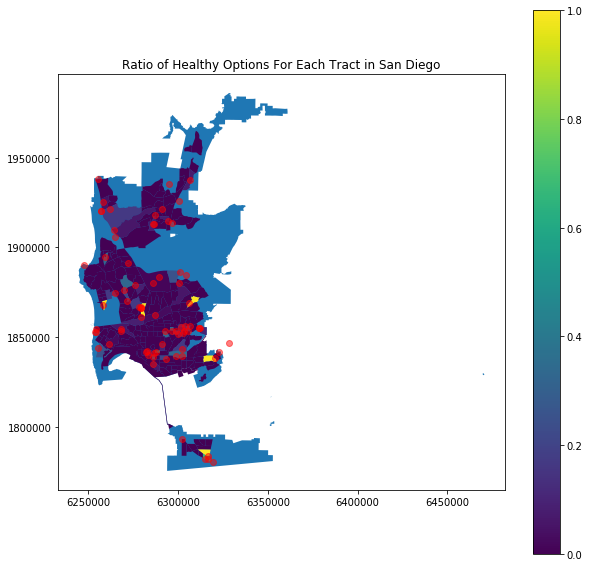

In [13]:
# Plots
ax1 = sd_juris.plot(figsize=(10,10))
inters_merged.plot(ax=ax1,column='ratios',legend=True)
noninters_merged.plot(ax=ax1,column='ratios')
h_buis_gdf.to_crs({'init':'epsg:2230'}).plot(ax=ax1, color='red',alpha=0.5)
ax1.set_title('Ratio of Healthy Options For Each Tract in San Diego')

Something we wanted to look into was to explore the availbility of public recreational centers around San Diego. Recreational centers are places where people can find affordable/free access to gyms. We were especially interested in whether the Promised Zone in additon to a lack of access to healthy food also had a lack of access to public recreational centers.

From the SANDAG Database there is a ShapeFile that contains all the recreational centers in San Diego.
Metadata can be found under Places category

In [14]:
rc_shp = 'data/Rec_Center_SD/Rec_Center_SD.shp'
rec_centers = gpd.read_file(rc_shp)

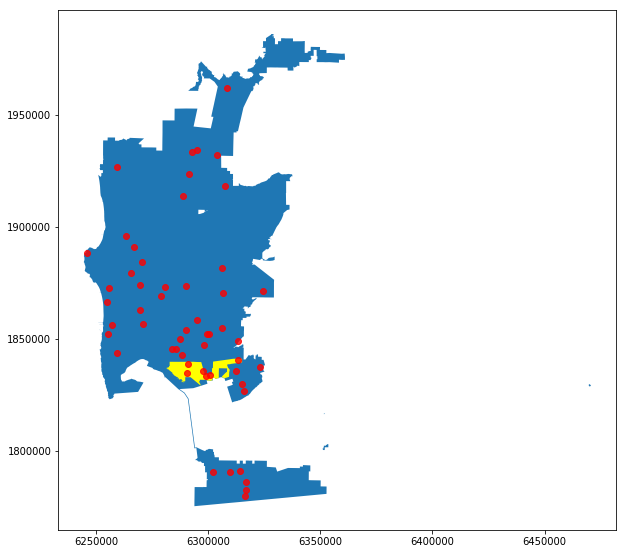

In [15]:
#Map of Rec Centers Around San Diego with Promise Zone Highlighted
base = sd_juris.plot(figsize=(10,10))
promise_zone.plot(ax=base,color='yellow')
rec_centers.to_crs({'init':'epsg:2230'}).plot(ax=base, color='red',alpha=0.8)


We also wanted to see if there was any correlation between tracts with high density of unhealthy options and access to recreational centers in the Promise Zone. A high correlation between the two could suggest that the San Diego government was at the very least promoting physical activity in areas with unhealthy options. If there is no correlation, increasing the amount of recreational center in areas with unhealthy options could be an alternative solution to providing more healthier options in the Promise Zone. 

In [16]:
#Rec Centers Intersecting with the Promise Zone
inters_rc = gpd.sjoin(rec_centers, intersecting, how='inner', op='within')
inters_rc_tracts = inters_rc['TRACT'].tolist()
inters_rc_tracts

[39.02, 30.04, 31.12, 35.02, 36.02, 40.0, 33.03]

In [17]:
#Calculate tracts that have Unhealthy Options and have Recreational Centers
#Note that a tract is labeled as high density of unhealthy options if there are 3 or more unhealthy options
def hasUH(lis):
    if (lis[1] >= 3):
        return 1
    else:
        return 0
inters_hasUH = inters_tract_num_health.apply(hasUH)

hasRC = []
for i in inters_hasUH.index:
    if i in inters_rc_tracts:
        hasRC.append(1)
    else:
        hasRC.append(0)
df_UH_and_RC = pd.DataFrame(data={'Has Unhealthy Option':inters_hasUH.tolist(),'Has Rec Center':hasRC})
df_UH_and_RC.corr()

,Has Unhealthy Option,Has Rec Center
Has Unhealthy Option,1.000000,-0.144338
Has Rec Center,-0.144338,1.000000


What we found was that there was no correlation between tracts having unhealthy options and having rec centers.

However, as mentioned above, providing more recreational centers in areas with a high density of unhealthy options could be an alternative solution to the lack of healthy options in the Promise Zone. At the very least, the lack of nutritious options could be combated with physical activity/exercise.
